In [ ]:
"""
CS895_Computational_Imaging_Spring_2025__
|
DNA_DAMAGE_QUANTIFICATION (DDQ)
CS895_CI_ddq_custom_model_training.ipynb
Created on Tue Feb 25 18:23:59 2025
@authors: Rochana Obadage and Kumushini Thennakoon
|
Referenced from: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb
"""


# cellpose 3.1

We will first install cellpose 3.1, check the GPU is working, and mount google drive to get your models and images.

## Installation

In [57]:
!pip install numpy==1.26.4

In [59]:
!pip install "opencv-python-headless<4.3"
!pip uninstall -y cellpose
!pip install "cellpose==3.1.1"

Found existing installation: cellpose 3.1.1
Uninstalling cellpose-3.1.1:
  Successfully uninstalled cellpose-3.1.1
Found existing installation: cellpose 3.1.1
Uninstalling cellpose-3.1.1:
  Successfully uninstalled cellpose-3.1.1
  Using cached cellpose-3.1.1-py3-none-any.whl.metadata (22 kB)
  Using cached cellpose-3.1.1-py3-none-any.whl.metadata (22 kB)
Using cached cellpose-3.1.1-py3-none-any.whl (225 kB)
Using cached cellpose-3.1.1-py3-none-any.whl (225 kB)


`Check CUDA version and that GPU is working in cellpose and import other libraries.`

In [60]:
# !nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

from natsort import natsorted

# import matplotlib.pyplot as plt
# import numpy as np
# from skimage import io


use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

Thu Oct  2 11:49:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8             14W /  285W |    7536MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:


train_files = natsorted(glob('train/*.tif'))
train_seg = natsorted(glob('train/*.npy'))

test_files = natsorted(glob('test/*.npy'))
test_seg = natsorted(glob('test/*.npy'))

NameError: name 'natsorted' is not defined

`what the training images look like + their labels`

In [ ]:
# %matplotlib inline
plt.figure(figsize=(12, 4), dpi=150)

for k, f in enumerate(train_files):
    # Load image
    img = io.imread(f)

    # Normalize image if needed
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # scale to [0, 1]

    # Plot image
    plt.subplot(2, len(train_files), k + 1)
    img = np.vstack((img, np.zeros_like(img)[:1]))  # Optional: remove if not needed
    img = img.transpose(1, 2, 0) if img.ndim == 3 else img
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")

    # Load and plot mask
    plt.subplot(2, len(train_files), len(train_files) + k + 1)
    seg_path = os.path.splitext(f)[0] + '_seg.npy'
    seg = np.load(seg_path, allow_pickle=True).item()
    masks = seg['masks'].squeeze()
    plt.imshow(masks, cmap='nipy_spectral')  # color-coded mask
    plt.axis('off')
    plt.title("Mask")


# Train model on manual annotations

## Training parameters

<font size = 2> **Paths for training, predictions and results**


<font size = 2>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images).

<font size = 2>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 2>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 2>**Training parameters**

<font size = 2>**`number_of_epochs`:** Input how many epochs the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [ ]:
train_dir = "train" 
test_dir = "test" 

#Define where the patch file will be saved
base = "cellpose"

# model name and path
from cellpose import models
initial_model = "nuclei" # ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "ddq_model_1"

# other parameters for training.
n_epochs =  100
Channel_to_use_for_training = "Red" # ["Grayscale", "Blue", "Green", "Red"]

# If you have a secondary channel that can be used for training, for instance nuclei, choose it here:
Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

# Advanced Parameters
Use_Default_Advanced_Parameters = True
learning_rate = 0.1 
weight_decay = 0.0001 

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = 'custom_models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [ ]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)

## Train new model

Using settings from form above, train model in notebook.

In [ ]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=model_path,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

## Evaluate on test data (optional)

If you have test data, check performance

In [ ]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data,
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


plot masks

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8), dpi=150)

for k, im in enumerate(test_data):
    # Copy image and normalize if needed
    img = im.copy()
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # Normalize to [0,1]

    # Optional padding (can remove if unnecessary)
    img = np.vstack((img, np.zeros_like(img)[:1]))

    # Transpose if in (C, H, W) format
    if img.ndim == 3 and img.shape[0] <= 4:
        img = img.transpose(1, 2, 0)

    # Plot original image
    plt.subplot(3, len(test_data), k + 1)
    plt.imshow(img)
    plt.axis('off')
    if k == 0:
        plt.title('Image')

    # Plot predicted mask
    plt.subplot(3, len(test_data), len(test_data) + k + 1)
    plt.imshow(masks[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('Predicted Labels')

    # Plot ground truth
    plt.subplot(3, len(test_data), 2 * len(test_data) + k + 1)
    plt.imshow(test_labels[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('True Labels')

plt.tight_layout()
plt.show()


# Use custom model to segment images

In [ ]:
model_path = "custom_models/models/ddq_model_1"
image_dir = "test" 

# Channel Parameters:

Channel_to_use_for_segmentation = "Red" # ["Grayscale", "Blue", "Green", "Red"]
Second_segmentation_channel= "None" # ["None", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

# Segmentation parameters:
# diameter of cells (set to zero to use diameter from training set):
diameter =  0 # {type:"number"}

# threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 # {type:"slider", min:0.0, max:3.0, step:0.1}

# threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 # {type:"slider", min:-6, max:6, step:1}

In [ ]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {image_dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

## run custom model

In [ ]:
# gets image files in dir (ignoring image files ending in _masks)
# get all .tif files
all_tifs = natsorted(glob(os.path.join(image_dir, '*.tif')))

# exclude any prediction masks
files = [f for f in all_tifs if not f.endswith('_cp_masks.tif')]
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [ ]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      files,
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)),
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [ ]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

In [ ]:
files[3]

In [ ]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output_cp_masks.png'))
plt.axis('off')

## .npy visualization

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.segmentation import find_boundaries
from cellpose import plot
from glob import glob
from natsort import natsorted
import os

# Get all _seg.npy files in the test folder - DEBUG VERSION
print("🔍 DEBUGGING: Let's check what files actually exist in the test folder...")

# First, let's see all files in the test directory
test_files_all = glob('test/*')
print(f"\n📁 All files in test folder ({len(test_files_all)} total):")
for f in sorted(test_files_all):
    print(f"  {f}")

# Now let's check for different patterns of _seg.npy files
patterns_to_check = [
    'test/*_seg.npy',           # All _seg.npy files
    'test/Groundtruth*_seg.npy', # Your original pattern
    'test/4Gy*_seg.npy',        # Based on your earlier files
    'test/8Gy*_seg.npy',        # Based on your earlier files
]

print(f"\n🔍 Checking different patterns:")
for pattern in patterns_to_check:
    files = natsorted(glob(pattern))
    print(f"  Pattern '{pattern}': Found {len(files)} files")
    for f in files:
        print(f"    {f}")

# Use the most comprehensive pattern
seg_files = natsorted(glob('test/*_seg.npy'))

print(f"\n🎯 FINAL RESULT: Found {len(seg_files)} _seg.npy files to visualize:")
for f in seg_files:
    print(f"  {f}")

if len(seg_files) == 0:
    print("❌ No _seg.npy files found in test folder!")
else:
    # Process each _seg.npy file
    for idx, seg_file in enumerate(seg_files):
        # Get image name from seg file
        img_name = os.path.splitext(seg_file)[0]  # Remove _seg.npy extension
        filename = os.path.basename(img_name)
        
        print(f"\n📖 Processing {idx+1}/{len(seg_files)}: {filename}")
        
        try:
            # Load Cellpose outputs
            seg_data = np.load(seg_file, allow_pickle=True).item()
            masks = seg_data['masks']
            flows = seg_data['flows']
            
            # Count cells
            n_cells = len(np.unique(masks)) - 1  # Subtract 1 for background
            print(f"  🔬 Detected {n_cells} cells")
            
            # Create visualization
            fig, axs = plt.subplots(1, 3, figsize=(20, 5))
            
            # Plot 1: Original image (if available)
            tif_file = f'{img_name}.tif'
            if os.path.exists(tif_file):
                img = imread(tif_file)
                # Handle multi-channel TIFFs
                if img.ndim == 3 and img.shape[0] <= 4:
                    img = np.moveaxis(img, 0, -1)
                
                # Use first channel for display
                if img.ndim == 3:
                    base_img = img[..., 0]
                else:
                    base_img = img
                    
                # Normalize if needed
                if base_img.max() > 255:
                    base_img = (base_img / base_img.max() * 255).astype(np.uint8)
                
                # Convert to RGB
                img_rgb = np.stack([base_img] * 3, axis=-1)
                
                axs[0].imshow(img_rgb)
                axs[0].set_title(f"Original Image\n{filename}")
                axs[0].axis('off')
            else:
                axs[0].text(0.5, 0.5, 'Original Image\nNot Available', 
                           ha='center', va='center', transform=axs[0].transAxes)
                axs[0].axis('off')
            
            # Plot 2: Cellpose masks
            im = axs[1].imshow(masks, cmap='nipy_spectral')
            axs[1].set_title(f"Cellpose Masks\n{n_cells} cells detected")
            axs[1].axis('off')
            
            # Plot 3: Outlines on original (if original exists)
            if os.path.exists(tif_file):
                # Generate boundaries
                outlines = find_boundaries(masks, mode='inner')
                # Draw red outlines on the image
                img_outline = img_rgb.copy()
                img_outline[outlines] = np.array([255, 0, 0], dtype=np.uint8)
                
                axs[2].imshow(img_outline)
                axs[2].set_title("Outlines on Original")
                axs[2].axis('off')
                
                # Save outline image
                outline_filename = f'{img_name}_outline.png'
                imsave(outline_filename, img_outline)
                print(f"  💾 Saved: {os.path.basename(outline_filename)}")
            else:
                # Just show the masks with outlines
                axs[2].imshow(masks, cmap='nipy_spectral')
                axs[2].set_title("Instance Masks")
                axs[2].axis('off')
            
            # Add overall title
            fig.suptitle(f"Segmentation Analysis: {filename}", fontsize=16, y=1.02)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"  ❌ Error processing {filename}: {str(e)}")
            continue
    
    print(f"\n✅ Visualization complete! Processed {len(seg_files)} segmentation files")
    print(f"📁 Outline images saved in the test directory")


🔍 DEBUGGING: Let's check what files actually exist in the test folder...

📁 All files in test folder (0 total):

🔍 Checking different patterns:
  Pattern 'test/*_seg.npy': Found 0 files
  Pattern 'test/Groundtruth*_seg.npy': Found 0 files
  Pattern 'test/4Gy*_seg.npy': Found 0 files
  Pattern 'test/8Gy*_seg.npy': Found 0 files

🎯 FINAL RESULT: Found 0 _seg.npy files to visualize:
❌ No _seg.npy files found in test folder!


In [50]:
# Let's check the current working directory and find the actual test files
import os
from glob import glob

print("🔍 DEBUGGING: Current working directory and file locations")
print("=" * 60)

current_dir = os.getcwd()
print(f"📍 Current working directory: {current_dir}")

# List all directories in current location
print(f"\n📁 Contents of current directory:")
for item in sorted(os.listdir('.')):
    item_path = os.path.join('.', item)
    if os.path.isdir(item_path):
        print(f"  📂 {item}/")
    else:
        print(f"  📄 {item}")

# Look for test folder in different locations
possible_test_paths = [
    'test',
    './test', 
    '../test',
    '/home/cse/Documents/fyp-Medvision Classifier/test'
]

print(f"\n🔍 Checking possible test folder locations:")
for test_path in possible_test_paths:
    if os.path.exists(test_path):
        print(f"  ✅ FOUND: {test_path}")
        seg_files = glob(f'{test_path}/*_seg.npy')
        print(f"     📊 _seg.npy files: {len(seg_files)}")
        for f in seg_files[:3]:  # Show first 3 files
            print(f"       {os.path.basename(f)}")
        if len(seg_files) > 3:
            print(f"       ... and {len(seg_files)-3} more")
    else:
        print(f"  ❌ NOT FOUND: {test_path}")

# Also check for any _seg.npy files anywhere in the current tree
print(f"\n🔍 Searching for ANY _seg.npy files in current directory tree:")
all_seg_files = glob('**/*_seg.npy', recursive=True)
print(f"Found {len(all_seg_files)} _seg.npy files total:")
for f in all_seg_files:
    print(f"  {f}")

🔍 DEBUGGING: Current working directory and file locations
📍 Current working directory: /home/cse/Documents/fyp-Medvision Classifier/new folder

📁 Contents of current directory:
  📄 4Gy_53BP1_1Hr_cp_masks.tif
  📄 4Gy_53BP1_1Hr_cp_masks_processed_visualization.png
  📄 4Gy_53BP1_1Hr_cp_masks_processed_visualization.tif
  📄 4Gy_53BP1_4Hr_cp_masks.tif
  📄 4Gy_53BP1_4Hr_cp_masks_processed_visualization.png
  📄 4Gy_53BP1_4Hr_cp_masks_processed_visualization.tif
  📄 4Gy_53BP1_8Hr_cp_masks.tif
  📄 4Gy_53BP1_8Hr_cp_masks_processed_visualization.png
  📄 4Gy_53BP1_8Hr_cp_masks_processed_visualization.tif
  📄 4Gy_gH2AX_1Hr_cp_masks.tif
  📄 4Gy_gH2AX_1Hr_cp_masks_processed_visualization.png
  📄 4Gy_gH2AX_1Hr_cp_masks_processed_visualization.tif
  📄 4Gy_gH2AX_8Hr_cp_masks.tif
  📄 4Gy_gH2AX_8Hr_cp_masks_processed_visualization.png
  📄 4Gy_gH2AX_8Hr_cp_masks_processed_visualization.tif
  📄 8Gy_53BP1_1Hr_cp_masks.tif
  📄 8Gy_53BP1_1Hr_cp_masks_processed_visualization.png
  📄 8Gy_53BP1_1Hr_cp_masks_proce

📊 Creating separate visualizations...


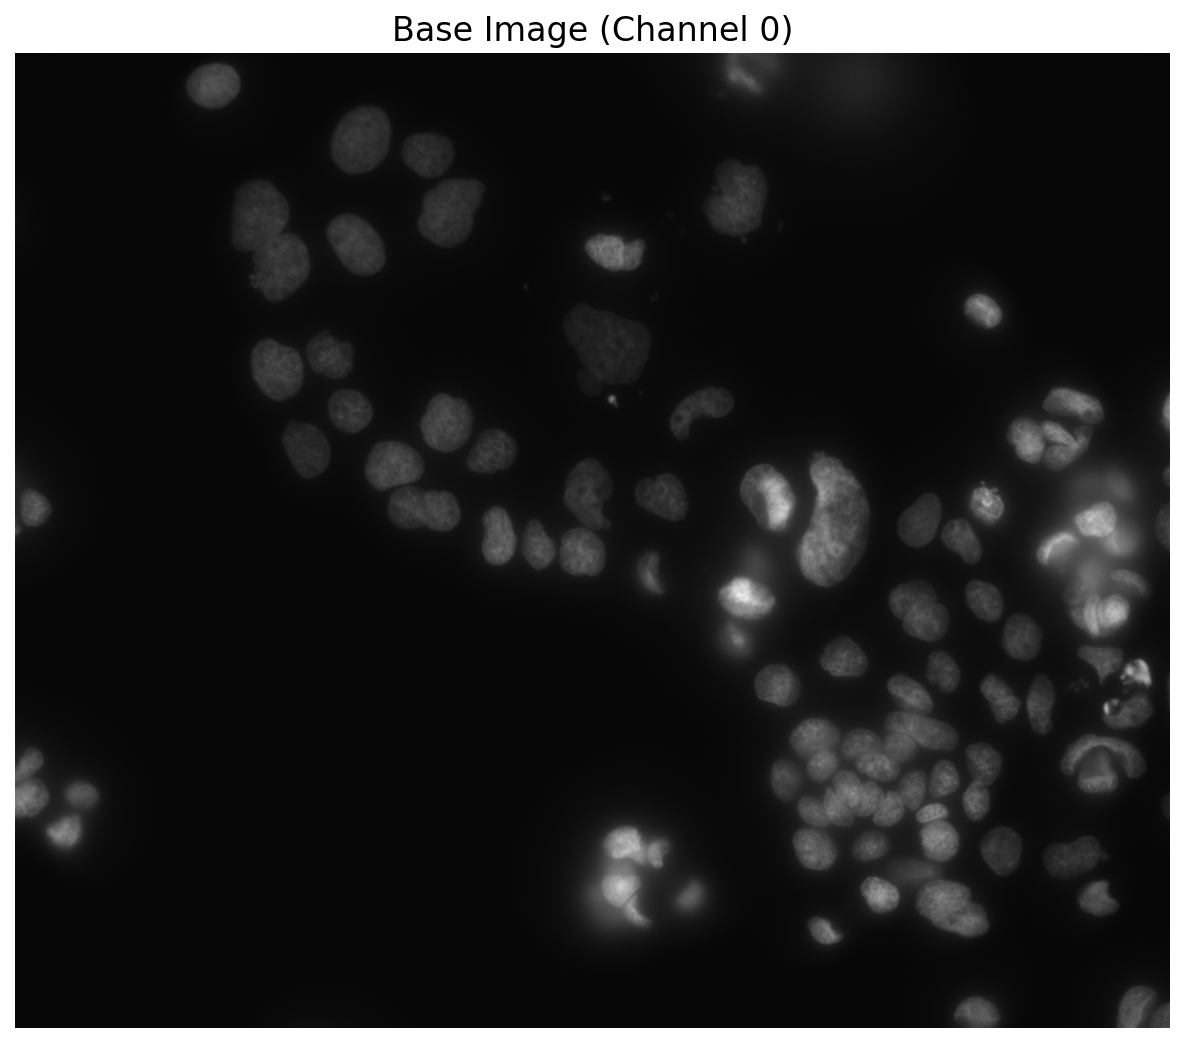

💾 Saved base image: test/groundtruth/8Gy_gH2AX_8Hr_base_image.png


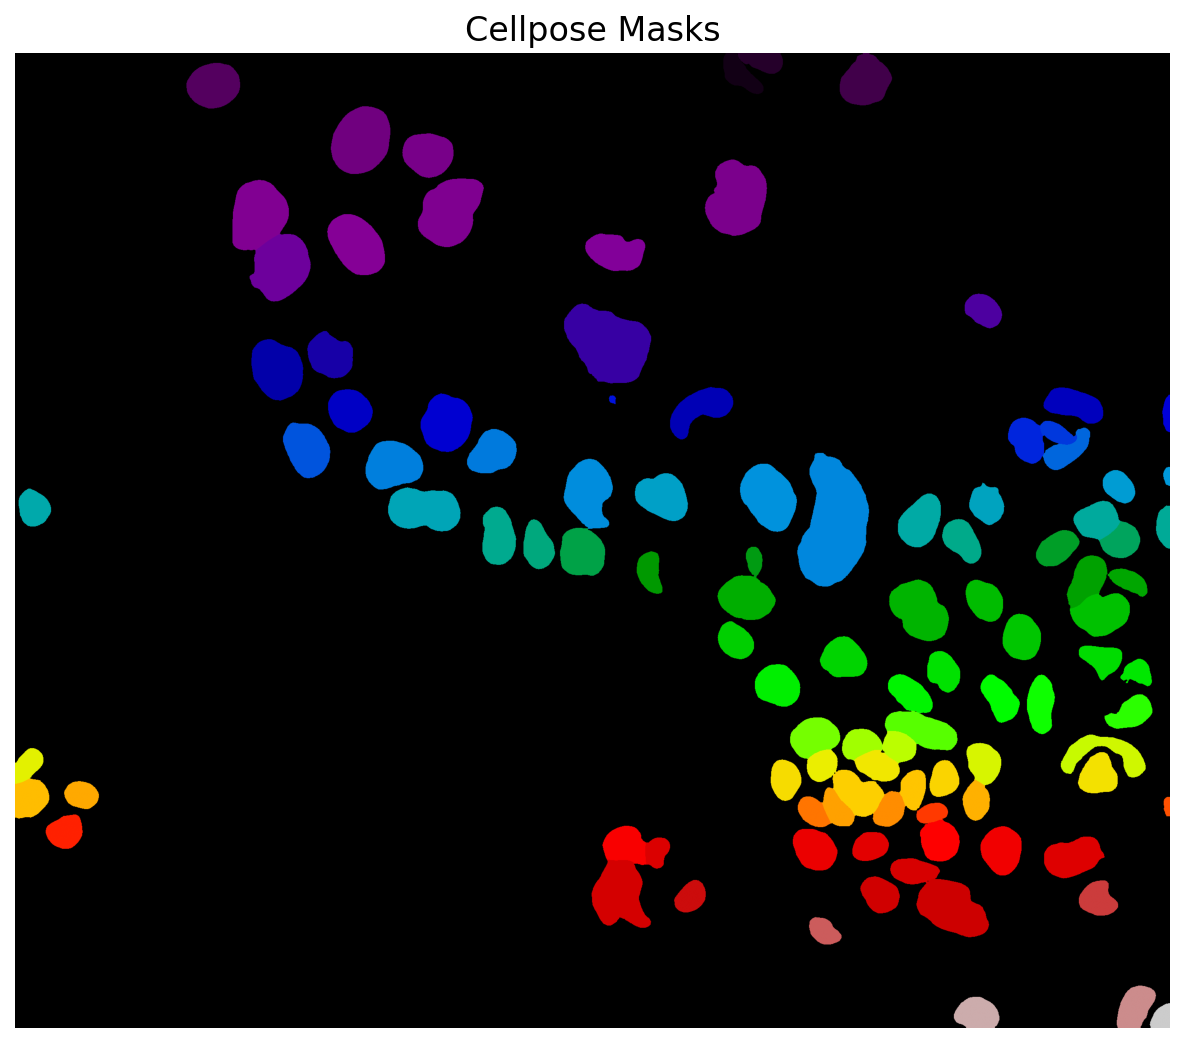

💾 Saved mask image: test/groundtruth/8Gy_gH2AX_8Hr_masks.png


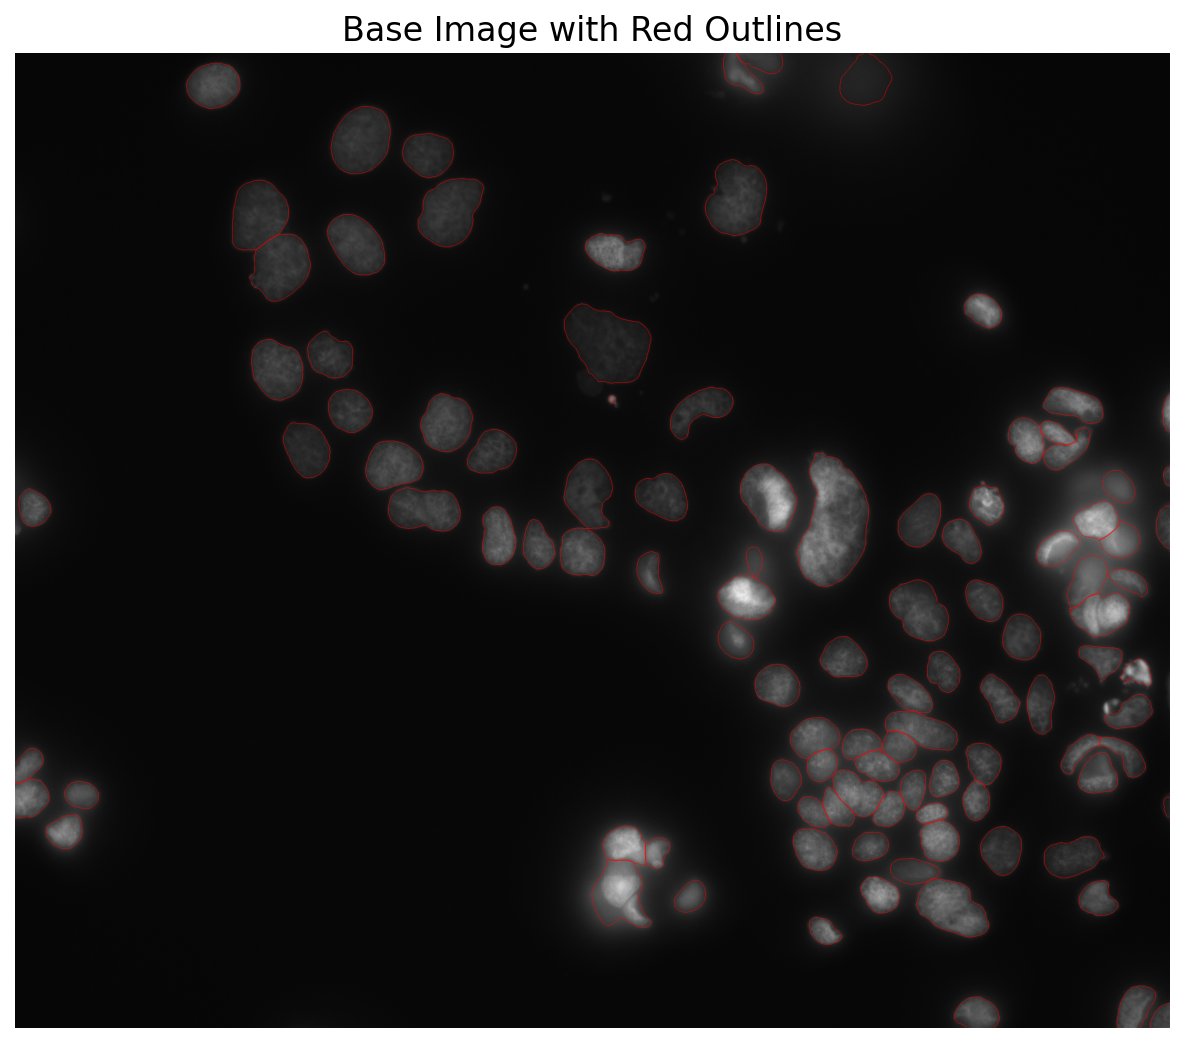

💾 Saved outlined image: test/groundtruth/8Gy_gH2AX_8Hr_outlined.png
🔬 Detected 106 cells in the image
📐 Image dimensions: 2160 x 2560 pixels
📊 Mask values range: 0 to 106


In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.segmentation import find_boundaries
from cellpose import plot

# Load TIFF image
img_name = 'test/8Gy_gH2AX_8Hr'
img = imread(f'{img_name}.tif')

# Handle (C, H, W) TIFFs
if img.ndim == 3 and img.shape[0] <= 4:
    img = np.moveaxis(img, 0, -1)

# At this point img shape = (H, W, 2)
H, W, C = img.shape
assert C == 2, f"Expected 2 channels, got {C}"

# Use first channel (e.g., blue = nuclei) as grayscale base for visualization
base_img = img[..., 0]  # or img[..., 1] if you prefer green

# Normalize if needed
if base_img.max() > 255:
    base_img = (base_img / base_img.max() * 255).astype(np.uint8)
else:
    base_img = base_img.astype(np.uint8)

# Convert to RGB (grayscale stacked 3 times)
img_rgb = np.stack([base_img] * 3, axis=-1)  # shape (H, W, 3)

# Load Cellpose outputs
seg_data = np.load(f'{img_name}_seg.npy', allow_pickle=True).item()
masks = seg_data['masks']
flows = seg_data['flows']

# Generate boundaries (outlines)
outlines = find_boundaries(masks, mode='inner')  # Generates boolean mask of boundaries

# Draw red outlines on the image
img_outline = img_rgb.copy()
img_outline[outlines] = np.array([255, 0, 0], dtype=np.uint8)  # Red color for outlines

# SEPARATE VISUALIZATIONS
print("📊 Creating separate visualizations...")

# Create groundtruth folder if it doesn't exist
groundtruth_folder = 'test/groundtruth'
os.makedirs(groundtruth_folder, exist_ok=True)

# Get filename for saving
filename = os.path.basename(img_name)

# 1. Base Image Only
plt.figure(figsize=(8, 8), dpi=150)
plt.imshow(img_rgb)
plt.title("Base Image (Channel 0)", fontsize=16)
plt.axis('off')
plt.tight_layout()
# Save base image
base_image_path = os.path.join(groundtruth_folder, f'{filename}_base_image.png')
plt.savefig(base_image_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"💾 Saved base image: {base_image_path}")

# 2. Cellpose Masks Only
plt.figure(figsize=(8, 8), dpi=150)
plt.imshow(masks, cmap='nipy_spectral')
plt.title("Cellpose Masks", fontsize=16)
plt.axis('off')  
plt.tight_layout()
# Save mask image
mask_image_path = os.path.join(groundtruth_folder, f'{filename}_masks.png')
plt.savefig(mask_image_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"💾 Saved mask image: {mask_image_path}")

# 3. Base Image with Red Outlines
plt.figure(figsize=(8, 8), dpi=150)
plt.imshow(img_outline)
plt.title("Base Image with Red Outlines", fontsize=16)
plt.axis('off')
plt.tight_layout()
# Save outlined image
outline_image_path = os.path.join(groundtruth_folder, f'{filename}_outlined.png')
plt.savefig(outline_image_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"💾 Saved outlined image: {outline_image_path}")

# Print statistics
n_cells = len(np.unique(masks)) - 1  # Subtract 1 for background
print(f"🔬 Detected {n_cells} cells in the image")
print(f"📐 Image dimensions: {H} x {W} pixels")
print(f"📊 Mask values range: {masks.min()} to {masks.max()}")

In [53]:
# Let's do a more thorough investigation of the file structure
import os
from glob import glob

print("🔍 THOROUGH FILE SYSTEM INVESTIGATION")
print("=" * 60)

# Check current directory
current_dir = os.getcwd()
print(f"📍 Current directory: {current_dir}")

# List ALL contents recursively to see the actual structure
print(f"\n📁 COMPLETE DIRECTORY STRUCTURE:")
for root, dirs, files in os.walk('.'):
    level = root.replace('.', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}📂 {os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        if file.endswith(('.npy', '.tif', '.png')):  # Only show relevant files
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path)
            print(f"{subindent}📄 {file} ({size} bytes)")

# Specifically look for _seg.npy files anywhere
print(f"\n🎯 SEARCHING FOR ALL _seg.npy FILES:")
seg_files = []
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('_seg.npy'):
            full_path = os.path.join(root, file)
            seg_files.append(full_path)
            
print(f"Found {len(seg_files)} _seg.npy files:")
for f in seg_files:
    print(f"  {f}")

# Check if the files from the browser image actually exist
expected_files = [
    'test/4Gy_53BP1_8Hr_seg.npy',
    'test/4Gy_gH2AX_8Hr_seg.npy', 
    'test/8Gy_53BP1_8Hr_seg.npy',
    'test/8Gy_gH2AX_8Hr_seg.npy'
]

print(f"\n🔍 CHECKING EXPECTED FILES FROM BROWSER:")
for expected in expected_files:
    if os.path.exists(expected):
        print(f"  ✅ EXISTS: {expected}")
    else:
        print(f"  ❌ MISSING: {expected}")
        
# Also check if test is actually a file vs directory
test_path = 'test'
if os.path.exists(test_path):
    if os.path.isdir(test_path):
        print(f"\n📂 'test' is a DIRECTORY")
        print(f"   Contents: {os.listdir(test_path)}")
    else:
        print(f"\n📄 'test' is a FILE (size: {os.path.getsize(test_path)} bytes)")
        
# Check parent directory too
parent_dir = os.path.dirname(current_dir)
print(f"\n📁 PARENT DIRECTORY: {parent_dir}")
parent_test = os.path.join(parent_dir, 'test')
if os.path.exists(parent_test) and os.path.isdir(parent_test):
    parent_test_files = [f for f in os.listdir(parent_test) if f.endswith('.npy')]
    print(f"   Parent test folder has {len(parent_test_files)} .npy files:")
    for f in parent_test_files[:5]:
        print(f"     {f}")

🔍 THOROUGH FILE SYSTEM INVESTIGATION
📍 Current directory: /home/cse/Documents/fyp-Medvision Classifier

📁 COMPLETE DIRECTORY STRUCTURE:
📂 ./
  📄 train_curve.png (91628 bytes)
  📂 test/
    📂 Groundtruth/
      📄 4Gy_53BP1_8Hr_seg.npy (127182065 bytes)
      📄 8Gy_gH2AX_8Hr_seg.npy (127181906 bytes)
      📄 8Gy_53BP1_1Hr_seg.npy (127181922 bytes)
      📄 4Gy_53BP1_1Hr_seg.npy (127182068 bytes)
      📄 8Gy_53BP1_4Hr_seg.npy (127181952 bytes)
      📄 4Gy_gH2AX_8Hr_seg.npy (127182047 bytes)
      📄 4Gy_53BP1_4Hr_seg.npy (127182008 bytes)
      📄 8Gy_53BP1_8Hr_seg.npy (127181882 bytes)
      📄 4Gy_gH2AX_1Hr_seg.npy (127181953 bytes)
  📂 .git/
    📂 info/
    📂 objects/
      📂 3e/
      📂 c9/
      📂 80/
      📂 6d/
      📂 9c/
      📂 8a/
      📂 61/
      📂 b2/
      📂 info/
      📂 12/
      📂 f2/
      📂 e8/
      📂 fd/
      📂 a0/
      📂 14/
      📂 2e/
      📂 65/
      📂 9e/
      📂 6c/
      📂 21/
      📂 3c/
      📂 35/
      📂 eb/
      📂 86/
      📂 f6/
      📂 2c/
      📂 20/
 

🔍 Current working directory: /home/cse/Documents/fyp-Medvision Classifier/new folder
🎯 Looking for files in: /home/cse/Documents/fyp-Medvision Classifier/new folder
✅ Folder exists!

🔍 Found 9 TIFF files in folder:
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_4Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_gH2AX_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_gH2AX_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_4Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_gH2AX_8Hr_cp_masks.tif
🎭 Detected 9 mask fi

🔍 Current working directory: /home/cse/Documents/fyp-Medvision Classifier/new folder
🎯 Looking for files in: /home/cse/Documents/fyp-Medvision Classifier/new folder
✅ Folder exists!

🔍 Found 9 TIFF files in folder:
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_4Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_gH2AX_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_gH2AX_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_4Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_gH2AX_8Hr_cp_masks.tif
🎭 Detected 9 mask fi

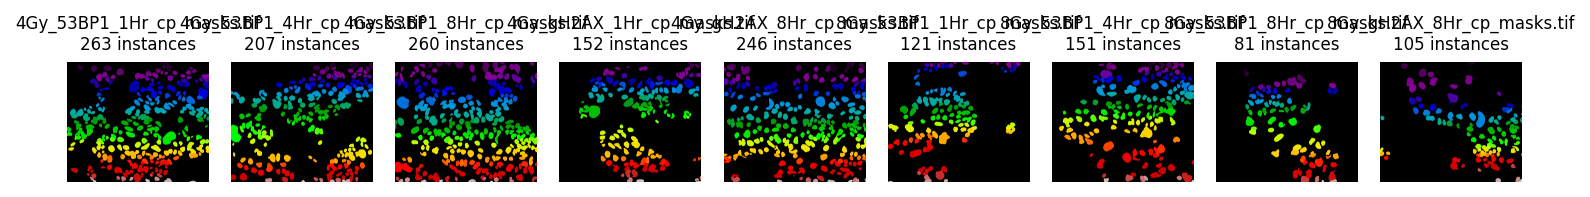

🔍 Current working directory: /home/cse/Documents/fyp-Medvision Classifier/new folder
🎯 Looking for files in: /home/cse/Documents/fyp-Medvision Classifier/new folder
✅ Folder exists!

🔍 Found 9 TIFF files in folder:
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_4Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_53BP1_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_gH2AX_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/4Gy_gH2AX_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_1Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_4Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_53BP1_8Hr_cp_masks.tif
  /home/cse/Documents/fyp-Medvision Classifier/new folder/8Gy_gH2AX_8Hr_cp_masks.tif
🎭 Detected 9 mask fi

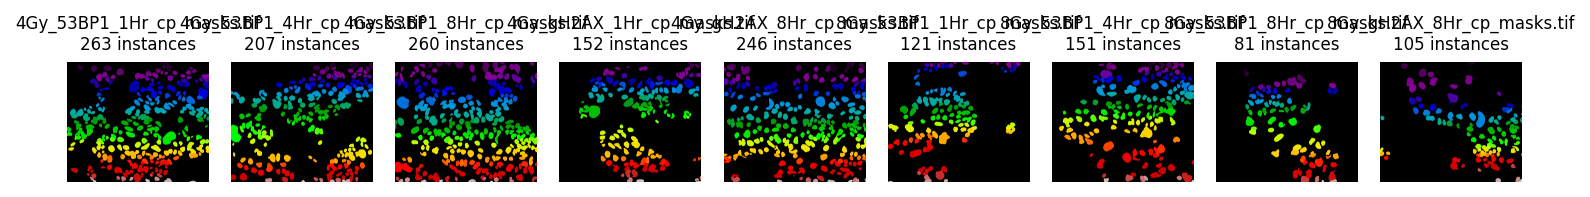


💾 SAVING PROCESSED MASKS:
  ✅ Saved: 4Gy_53BP1_1Hr_cp_masks_processed_visualization.tif
  ✅ Saved visualization: 4Gy_53BP1_1Hr_cp_masks_processed_visualization.png
  ✅ Saved: 4Gy_53BP1_4Hr_cp_masks_processed_visualization.tif
  ✅ Saved visualization: 4Gy_53BP1_1Hr_cp_masks_processed_visualization.png
  ✅ Saved: 4Gy_53BP1_4Hr_cp_masks_processed_visualization.tif
  ✅ Saved visualization: 4Gy_53BP1_4Hr_cp_masks_processed_visualization.png
  ✅ Saved: 4Gy_53BP1_8Hr_cp_masks_processed_visualization.tif
  ✅ Saved visualization: 4Gy_53BP1_4Hr_cp_masks_processed_visualization.png
  ✅ Saved: 4Gy_53BP1_8Hr_cp_masks_processed_visualization.tif
  ✅ Saved visualization: 4Gy_53BP1_8Hr_cp_masks_processed_visualization.png
  ✅ Saved: 4Gy_gH2AX_1Hr_cp_masks_processed_visualization.tif
  ✅ Saved visualization: 4Gy_53BP1_8Hr_cp_masks_processed_visualization.png
  ✅ Saved: 4Gy_gH2AX_1Hr_cp_masks_processed_visualization.tif
  ✅ Saved visualization: 4Gy_gH2AX_1Hr_cp_masks_processed_visualization.png
  ✅ Sav

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from cellpose import io
from glob import glob
from natsort import natsorted
import os

# Get current working directory for debugging
current_dir = os.getcwd()
print(f"🔍 Current working directory: {current_dir}")

# Use absolute path to avoid directory confusion
base_path = "/home/cse/Documents/fyp-Medvision Classifier"
new_folder = os.path.join(base_path, "new folder")

print(f"🎯 Looking for files in: {new_folder}")

# Check if the folder exists
if not os.path.exists(new_folder):
    print(f"❌ Folder '{new_folder}' does not exist!")
    # List what's actually in the base directory
    print(f"📁 Contents of {base_path}:")
    for item in os.listdir(base_path):
        print(f"  {item}")
else:
    print(f"✅ Folder exists!")

# Get ALL TIFF files from the new folder (including mask files)
new_folder_files = natsorted(glob(f'{new_folder}/*.tif'))

print(f"\n🔍 Found {len(new_folder_files)} TIFF files in folder:")
for f in new_folder_files:
    print(f"  {f}")

# Check if these are mask files
mask_files = [f for f in new_folder_files if '_cp_masks' in f or '_mask' in f]
if mask_files:
    print(f"🎭 Detected {len(mask_files)} mask files - treating as instance masks")

if len(new_folder_files) == 0:
    print(f"❌ No .tif images found in '{new_folder}' folder!")
    print("💡 Make sure the folder name is correct and files exist")
else:
    plt.figure(figsize=(10, 6), dpi=150)

    for k, f in enumerate(new_folder_files):
        # Load the file
        img = io.imread(f)
        filename = os.path.basename(f)
        
        # Check if this is an instance mask file
        if '_cp_masks' in f or '_mask' in f:
            # This is an instance mask - display with colors
            unique_labels = np.unique(img)
            n_instances = len(unique_labels) - 1 if 0 in unique_labels else len(unique_labels)
            
            plt.subplot(1, len(new_folder_files), k + 1)
            plt.imshow(img, cmap='nipy_spectral', vmin=0, vmax=img.max())
            plt.axis('off')
            plt.title(f"{filename}\n{n_instances} instances", fontsize=8)
            
        else:
            # Regular image processing
            # Handle multi-channel images
            if img.ndim == 3 and img.shape[0] <= 4:
                img = img.transpose(1, 2, 0)
                img_display = img[:, :, 0] if img.shape[2] > 1 else img
            else:
                img_display = img

            # Normalize image if needed
            if img_display.dtype != np.uint8:
                img_display = img_display.astype(np.float32)
                img_display /= img_display.max() if img_display.max() > 0 else 1

            plt.subplot(1, len(new_folder_files), k + 1)
            plt.imshow(img_display, cmap='gray')
            plt.axis('off')
            plt.title(f"{filename}", fontsize=8)

    plt.tight_layout()
    plt.show()

    # Save the instance masks back to the same folder
    if mask_files:
        print(f"\n💾 SAVING PROCESSED MASKS:")
        for f in new_folder_files:
            if '_cp_masks' in f or '_mask' in f:
                # Load the mask
                img = io.imread(f)
                filename = os.path.basename(f)
                
                # Create output filename (add '_processed' to distinguish)
                name_without_ext = os.path.splitext(filename)[0]
                output_filename = f"{name_without_ext}_processed_visualization.tif"
                output_path = os.path.join(new_folder, output_filename)
                
                # Save the mask back as TIFF
                io.imsave(output_path, img)
                print(f"  ✅ Saved: {output_filename}")
                
                # Also save as PNG for easy viewing
                png_filename = f"{name_without_ext}_processed_visualization.png"
                png_path = os.path.join(new_folder, png_filename)
                
                # Create a colorful visualization for PNG
                import matplotlib.pyplot as plt
                fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
                im = ax.imshow(img, cmap='nipy_spectral', vmin=0, vmax=img.max())
                ax.axis('off')
                
                unique_labels = np.unique(img)
                n_instances = len(unique_labels) - 1 if 0 in unique_labels else len(unique_labels)
                
                # Save as PNG
                plt.savefig(png_path, bbox_inches='tight', dpi=150)
                plt.close()  # Close to free memory
                
                print(f"  ✅ Saved visualization: {png_filename}")

    # Print summary
    print(f"\n📊 VISUALIZATION COMPLETE")
    print(f"✅ Successfully displayed {len(new_folder_files)} files from folder")
    
    if mask_files:
        print(f"🎨 Instance masks displayed with colorful visualization (nipy_spectral colormap)")
        print(f"🔢 Each unique instance/cell has a different color")
        print(f"💾 Processed masks saved back to '{os.path.basename(new_folder)}' folder")
        
        # Print detailed statistics
        print(f"\n📈 INSTANCE STATISTICS:")
        for f in new_folder_files:
            img = io.imread(f)
            unique_labels = np.unique(img)
            n_instances = len(unique_labels) - 1 if 0 in unique_labels else len(unique_labels)
            filename = os.path.basename(f)
            
    else:
        print(f"🖼️ Regular images displayed")